In [1]:
# Standard modules
import pdb
import sys
import os
import pickle
import numpy as np
import pandas as pd
from lmfit import Parameters, minimize, fit_report
import matplotlib.pyplot as plt
from matplotlib import gridspec

import warnings
warnings.filterwarnings("ignore")

sys.path.append("../../../..")

from simstackwrapper import SimstackWrapper
from simstackresults import SimstackResults
from simstackplots import SimstackPlots
from simstacktoolbox import SimstackToolbox

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
# Import catalog with SimstackWrapper
combined_pickle_filename = "sides_allz_nuvrj_0p01_0p5_1_1p5_2_2p5_3_4_5_6p0_X_4_foregnd_atonce_bootstrap_1-70"
combined_pickle_path = os.environ['PICKLESPATH']+'/'+os.path.join("simstack","stacked_flux_densities", "spire" , combined_pickle_filename)
underscore_suffix = ""
path_ini_file = os.path.join(combined_pickle_path, "sides_simulation.ini")
path_pickle_file = os.path.join(combined_pickle_path, combined_pickle_filename+".pkl")
if os.path.isfile(path_ini_file):
    simstack_catalog_object = SimstackWrapper(path_ini_file, read_maps=False, read_catalog=True, keep_catalog=True, stack_automatically=False, save_automatically=False)
else:
    print(path_ini_file+' not found')

In [3]:
# Import saved stacking results
simstack_object = SimstackToolbox.import_saved_pickles(path_pickle_file)

In [4]:
# Pass saved results into SimstackResults
simstack_object = SimstackResults(simstack_object)

In [5]:
# Pass saved results into SimstackPlots
simstack_object = SimstackPlots(simstack_object)

In [6]:
# Call parse_results which translates the raw results into a results_dict for plotting/interpreting.
simstack_object.parse_results(catalog_object=simstack_catalog_object, estimate_mcmcs=False)

In [7]:
# Extract SEDs Dict
sed_results_dict = simstack_object.results_dict['sed_bootstrap_results_dict']

In [8]:
# Extract Bootstrap Dict
bootstrap_results_dict = simstack_object.results_dict['bootstrap_results_dict']

In [9]:
def black( nu_in, T):
    # h = 6.623e-34     ; Joule*s
    # k = 1.38e-23      ; Joule/K
    # c = 3e8           ; m/s
    # (2*h*nu_in^3/c^2)*(1/( exp(h*nu_in/k*T) - 1 )) * 10^29

    a0 = 1.4718e-21  # 2*h*10^29/c^2
    a1 = 4.7993e-11  # h/k

    num = a0 * nu_in ** 3.0
    den = np.exp(a1 * np.outer(1.0 / T, nu_in)) - 1.0
    ret = num / den

    return ret

In [10]:
def graybody_fn(theta, x, alphain=2.0, betain=1.8):
    A, T = theta

    c_light = 299792458.0  # m/s

    nu_in = np.array([c_light * 1.e6 / wv for wv in x])
    ng = np.size(A)

    base = 2.0 * (6.626) ** (-2.0 - betain - alphain) * (1.38) ** (3. + betain + alphain) / (2.99792458) ** 2.0
    expo = 34.0 * (2.0 + betain + alphain) - 23.0 * (3.0 + betain + alphain) - 16.0 + 26.0
    K = base * 10.0 ** expo
    w_num = 10 ** A * K * (T * (3.0 + betain + alphain)) ** (3.0 + betain + alphain)
    w_den = (np.exp(3.0 + betain + alphain) - 1.0)
    w_div = w_num / w_den
    nu_cut = (3.0 + betain + alphain) * 0.208367e11 * T
    graybody = np.reshape(10 ** A, (ng, 1)) * nu_in ** np.reshape(betain, (ng, 1)) * black(nu_in, T) / 1000.0
    powerlaw = np.reshape(w_div, (ng, 1)) * nu_in ** np.reshape(-1.0 * alphain, (ng, 1))
    graybody[np.where(nu_in >= np.reshape(nu_cut, (ng, 1)))] = \
        powerlaw[np.where(nu_in >= np.reshape(nu_cut, (ng, 1)))]

    return graybody

In [11]:
def fast_sed(m, wavelengths):

    v = m.valuesdict()
    A = np.asarray(v['A'])
    T = np.asarray(v['T_observed'])
    betain = np.asarray(v['beta'])
    alphain = np.asarray(v['alpha'])
    theta_in = A, T

    return graybody_fn(theta_in, wavelengths, alphain=alphain, betain=betain)

In [12]:
def find_sed_min(params, wavelengths, fluxes, covar=None):

    graybody = fast_sed(params, wavelengths)[0]
    delta_y = (fluxes - graybody)

    if (covar is None) or (np.sum(covar) == 0):
        return delta_y
    else:
        if np.shape(covar) == np.shape(fluxes):
            return delta_y ** 2 / covar
        else:
            return np.matmul(delta_y**2, np.linalg.inv(covar))

In [13]:
def fast_sed_fitter(wavelengths, fluxes, covar=None, betain=1.8, alphain=2.0, redshiftin=0, stellarmassin=None):

    t_in = (23.8 + 2.7 * redshiftin + 0.9 * redshiftin ** 2) / (1 + redshiftin)
    if stellarmassin is not None:
        a_in = -47 - redshiftin*0.05 + 11 * (stellarmassin / 10)
    else:
        a_in = -35.0
    a_in = -35.0
    #print(t_in, a_in)
    fit_params = Parameters()
    fit_params.add('A', value=a_in, vary=True)
    fit_params.add('T_observed', value=t_in, vary=True)
    fit_params.add('beta', value=betain, vary=False)
    fit_params.add('alpha', value=alphain, vary=False)

    fluxin = fluxes #[np.max([i, 1e-7]) for i in fluxes]
    try:
        sed_params = minimize(find_sed_min, fit_params,
                              args=(wavelengths,),
                              kws={'fluxes': fluxin, 'covar': covar})
        m = sed_params.params
    except:
        m = fit_params

    return m

In [14]:
def estimate_single_sed(wavelengths, fluxes, z, m):

    sed_params = fast_sed_fitter(wavelengths, fluxes, covar=None, redshiftin=z, stellarmassin=m)
    
    return sed_params

In [15]:
catalog_with_trf = simstack_catalog_object.catalog_dict['tables']['full_table']

In [16]:
catalog_with_trf.head()

,Unnamed: 0,redshift,ra,dec,Mstar,qflag,SFR,LIR,SMIPS24,S100,S160,SSPIRE250,SSPIRE350,SSPIRE500,S850,Trf,Ain
0,0,0.027082,1.386314,0.578664,1.166001e+10,False,2.131869,2.131869e+10,0.031750,0.978360,0.992486,0.500539,0.215010,0.078771,0.013884,24.484551,-33.448240
1,1,0.028948,0.653517,1.053531,4.891516e+09,False,0.921371,9.213706e+09,0.016367,0.338908,0.301663,0.140840,0.057914,0.020618,0.003558,26.147824,-34.070478
2,2,0.028611,0.787421,0.940826,1.672992e+09,False,0.268678,2.686784e+09,0.004879,0.099181,0.086771,0.040053,0.016370,0.005806,0.001000,26.372738,-34.625885
3,3,0.027862,0.953034,0.135157,3.129536e+09,False,0.366717,3.667170e+09,0.006763,0.147761,0.137267,0.065616,0.027400,0.009853,0.001718,25.576352,-34.378675
4,4,0.038581,0.486818,1.373688,3.277258e+10,False,0.681084,6.810841e+09,0.004888,0.153104,0.165012,0.085557,0.037465,0.013870,0.002472,24.107978,-34.182750


In [21]:
def compare_sides_tdust(self, catalog, results_dict):
    bin_keys = list(self.config_dict['parameter_names'].keys())
    par_keys = self.config_dict['parameter_names']
    wv_keys = list(self.results_dict['band_results_dict'].keys())
    
    wavelengths = [24, 100, 160, 250, 350, 500]
    wv_mod = np.linspace(8,1000,1000)
    
    zlen = len(self.config_dict['parameter_names'][bin_keys[0]])
    mlen = len(self.config_dict['parameter_names'][bin_keys[1]])
    plen = len(self.config_dict['parameter_names'][bin_keys[2]])
    wlen = len(wv_keys)
    
    width_ratios = [i for i in np.ones(zlen)]
    gs = gridspec.GridSpec(mlen, zlen, width_ratios=width_ratios,
                           wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845)

    fig = plt.figure(figsize=(4 * zlen, 10))    

    color = ['b', 'y', 'g', 'r']
    if len(self.config_dict['parameter_names']) == 3:
        for iz, zlab in enumerate(self.config_dict['parameter_names'][bin_keys[0]]):
            zmid = 0.5 * np.sum([float(i) for i in zlab.split('_')[-2:]])
            for ip, plab in enumerate(self.config_dict['parameter_names'][bin_keys[2]]):
                if not ip:
                    for im, mlab in enumerate(self.config_dict['parameter_names'][bin_keys[1]]):
                        id_label = "__".join([zlab, mlab, plab])

                        ax = plt.subplot(gs[3-im, iz])
                        ax.set_title(zlab.replace('redshift_','z=').replace('_','-'))
                        ax.set_yticklabels([])
                        ax.set_xlim([20,55])
                        
                        m = [float(i) for i in mlab.split('_')[2:]]
                        z = [float(i) for i in par_keys['redshift'][iz].split('_')[1:]]

                        ind_bin = (catalog['redshift'] > z[0]) & \
                            (catalog['redshift'] < z[1]) & \
                            (catalog['Mstar'] >= 10**m[0]) & \
                            (catalog['Mstar'] < 10**m[1]) & \
                            (catalog['qflag'] == ip)
                        
                        t_vals = catalog['Trf'].loc[ind_bin]
                        hb = np.linspace(20,60,41)
                        hy, hx = np.histogram(t_vals, bins=hb)
                        ax.step((hx[:-1]+hx[1:])/2, hy, c=color[im])

                        ax.vlines(np.mean(t_vals), min(hy), max(hy), color=color[im], ls='--', lw=2, label='sides={0:.1f}K'.format(np.mean(t_vals)))
                        
                        # Simstacked SIDES SEDs
                        fluxes = results_dict['sed_fluxes_dict'][id_label]
                        zin = np.mean(catalog['redshift'].loc[ind_bin])
                        mm = np.mean(catalog['Mstar'].loc[ind_bin])
                        single_sed_params = estimate_single_sed(wavelengths, fluxes, zin, np.log10(mm))

                        ax.vlines(single_sed_params['T_observed'].value * (1+zin) , min(hy), max(hy), color='k', ls=':', lw=3, label='simstack={0:.1f}K'.format( single_sed_params['T_observed'].value * (1+zin) ))

                        if im:
                            ax.set_xticklabels([])
                        else:
                            ax.set_xlabel('T_rf [K]')

                        ax.legend(loc='lower left')


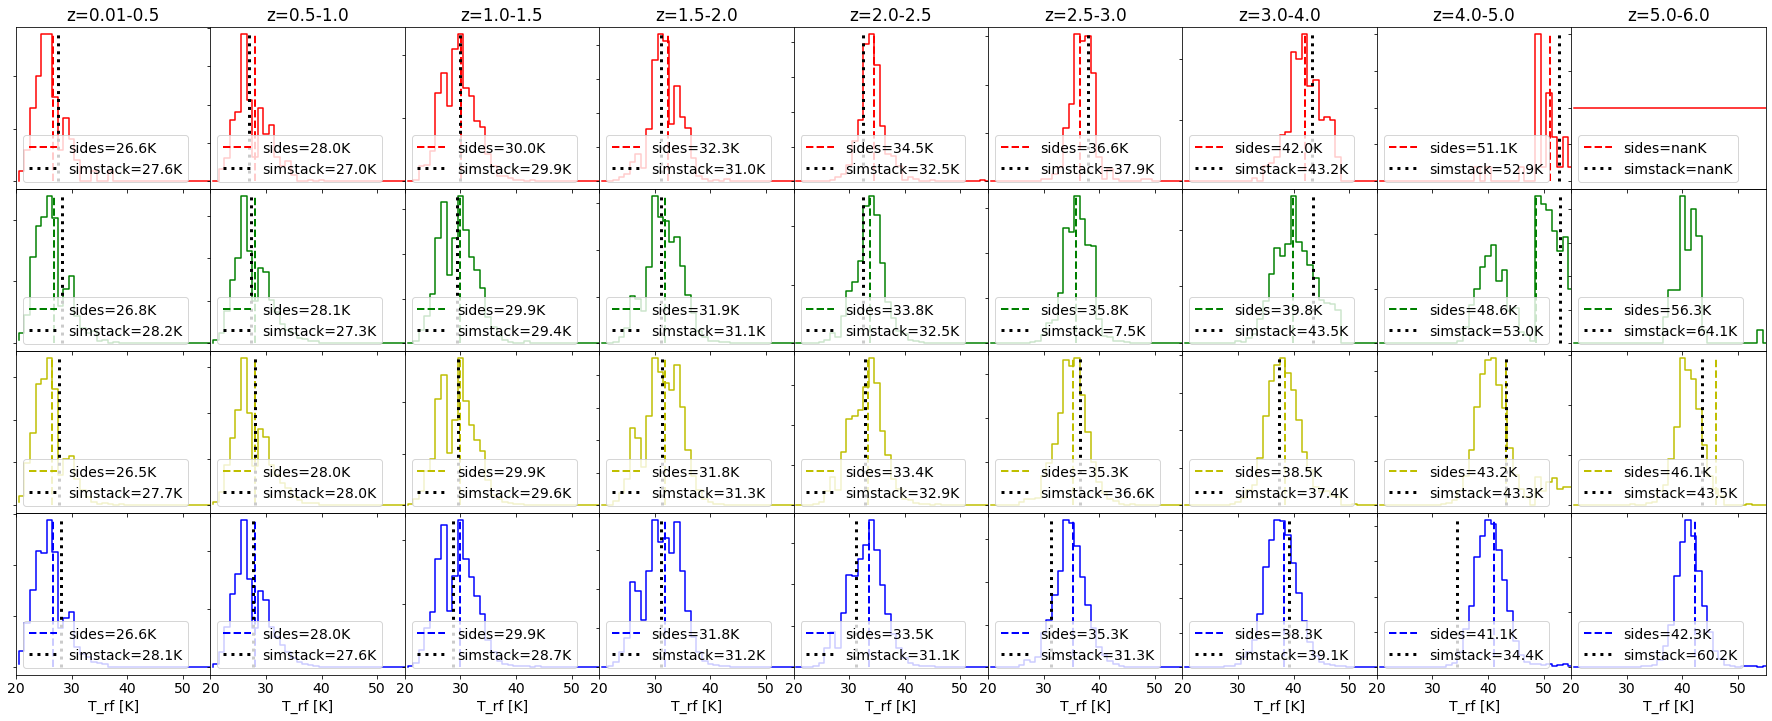

In [22]:
compare_sides_tdust(simstack_catalog_object, catalog_with_trf, sed_results_dict)